In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#### Data manipulation

I have dowloaded raw data and mortality tables for females for comparison. Going forwards analysis is restricted to female population of Switzerland for selected generations

https://www.mortality.org/Country/Country?cntr=CHE

In [2]:
df_deaths_raw = pd.read_csv(r'C:\Users\tskor\Documents\GitHub\life_modelling\CHEdeath.txt')
df_pop_raw = pd.read_csv(r'C:\Users\tskor\Documents\GitHub\life_modelling\CHEpop.txt')

df_deaths = df_deaths_raw[(df_deaths_raw['Sex']=='f')
                         &(df_deaths_raw['LDB']==1)]
df_pop = df_pop_raw[(df_pop_raw['Sex']=='f')
                   &(df_pop_raw['LDB']==1)
                   ]

df_deaths = df_deaths[['Year', 'Sex', 'Age', 'Lexis', 'Deaths']]
df_pop = df_pop[['Year', 'Sex', 'Age', 'Population']]



C:\Users\tskor\AppData\Local\Temp\ipykernel_20356\3410856499.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_deaths_raw = pd.read_csv(r'C:\Users\tskor\Documents\GitHub\life_modelling\CHEdeath.txt')


In [3]:
#Add information about generations to the data frame
df_deaths['Generation'] = np.where(df_deaths['Lexis']=='TU', df_deaths['Year'] - df_deaths['Age'] - 1, df_deaths['Year'] - df_deaths['Age'])
df_pop['Generation'] = df_pop['Year'] - df_pop['Age']

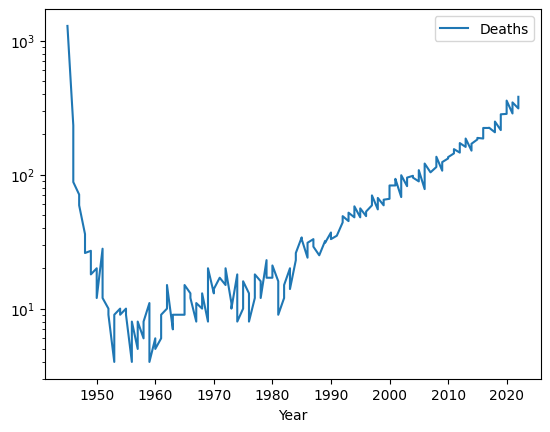

In [4]:
#plot sample feneration data, resonability check
df_deaths[df_deaths['Generation']==1945].plot(kind='line', x='Year', y='Deaths', logy=True)
plt.show()

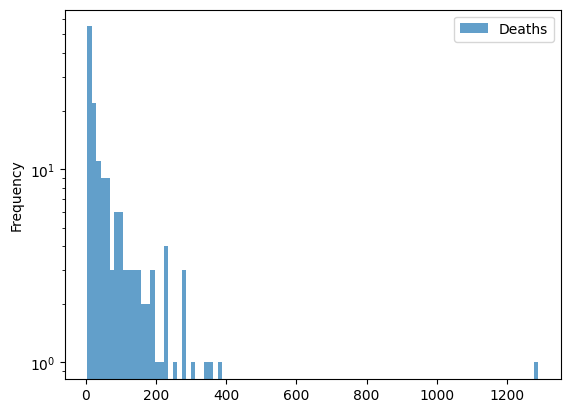

In [5]:
df_deaths[df_deaths['Generation']==1945].plot(kind='hist', log=True, bins=100, y=['Deaths'], alpha=0.7)
plt.show()

In [6]:
#I have downloaded mortality tables for females based on the raw data

def get_generation_data(gens, df):
    return df[df['Generation'].isin(gens)]

#### Raw mortality rates

In [7]:
#get 1945 population data - post WW2 looking quite reasonable in terms of shape

gen = [1945]
df_mmli_death = get_generation_data(gen, df_deaths)
df_mmli_pop = get_generation_data(gen, df_pop)

##### YoB/YoD Method - not possible to calculate and get reasonable result as clearly we don't have closed population

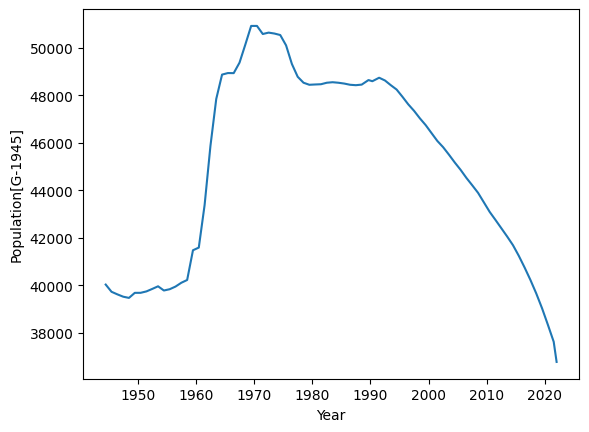

In [27]:
#assume for ages with multiple population count per age average result
df_mmli_pop.groupby(by='Age')[['Year', 'Population']].mean().plot(kind='line', x='Year', y='Population',ylabel='Population[G-1945]',legend=False)
plt.show()


Population canot be closed since the number of people within the population increases

##### Mortality coefficient method

In [37]:
#Prepare data

#Two generations are necessary to calculate raw mortality rates in MCM
gen = [1944, 1945]
gen_pop = [1945, 1946]
df_mmli_death = get_generation_data(gen, df_deaths)
df_mmli_pop = get_generation_data(gen_pop, df_pop)

df_mmli_death_mcm = df_mmli_death.groupby(by=['Year', 'Age']).agg({'Age':'count', 'Year':'min', 'Deaths':'sum'})
df_mmli_death_mcm = df_mmli_death_mcm[df_mmli_death_mcm['Age']==2][['Year','Deaths']].reset_index(drop=True)

In [47]:
df_mmli_pop_mcm = df_mmli_pop.groupby(by='Age')[['Year', 'Population']].agg({'Year':'min', 'Population':'mean'}).reset_index()

             Age         Year    Population         Year       Deaths  \
count  78.000000    78.000000     78.000000    78.000000    78.000000   
mean   38.500000  1983.500000  45891.288462  1983.500000   156.666667   
std    22.660538    22.660538   3863.923183    22.660538   234.563517   
min     0.000000  1945.000000  37660.000000  1945.000000     8.000000   
25%    19.250000  1964.250000  41466.000000  1964.250000    24.250000   
50%    38.500000  1983.500000  47221.750000  1983.500000    55.000000   
75%    57.750000  2002.750000  49014.375000  2002.750000   187.250000   
max    77.000000  2022.000000  51089.500000  2022.000000  1544.000000   

         q_x_mcm  
count  78.000000  
mean    0.003619  
std     0.005733  
min     0.000193  
25%     0.000511  
50%     0.001143  
75%     0.004113  
max     0.036925  


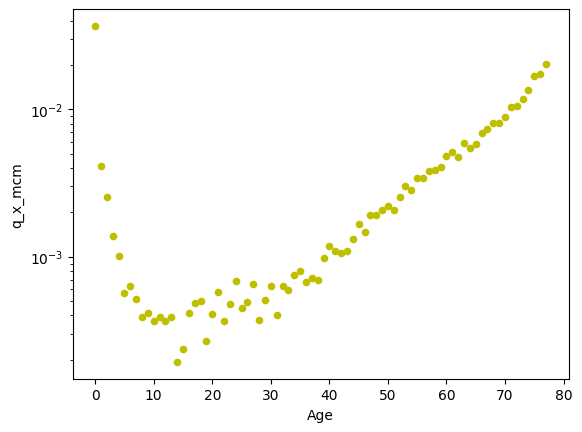

In [48]:
df_mmli = pd.concat([df_mmli_pop_mcm, df_mmli_death_mcm], axis=1)
df_mmli['q_x_mcm']= df_mmli['Deaths'] / (df_mmli['Deaths'] * 0.5 + df_mmli['Population'])

print(df_mmli.describe())
df_mmli.plot(kind='scatter', y='q_x_mcm', x='Age', c='y', logy=True)
plt.show()

##### Exposure Method

No data to estimate exposure, raw rates based on the MCM only

#### Smoothing

##### Mechanical smoothing

In [49]:
def mech_smooth(mort_rates, weights):
    """Function to smooth mortality mechanically smooth mortality rates.
       Smoothed rates are weighted average of the raw rates in the neighberhood 

       Only rates that can get fool smoothing will be treated

    Args:
        mort_rates (np.arry): raw mortality rates to be smoothed
        weights (np.arry): arry of wegihts with odd length summing-up to 1
    """
    assert(len(weights) % 2==1)
    assert(np.round(sum(weights),10)==1)

    avg_window = len(weights)
    iter = 0
    smooth_q = np.array([])
    for idx, q in enumerate(mort_rates):
        if (idx < avg_window // 2) or (idx >= len(mort_rates) - avg_window // 2):
            smooth_q = np.append(smooth_q, q)
        else:
            smooth_q = np.append(smooth_q,
                                 np.sum(mort_rates[iter:iter + avg_window] * weights))
            iter += 1

    return np.array(smooth_q)


In [50]:
#mech smooting with span 5 and 9 with equal weights
for w_len in [5,9]:
    weights = np.array([1]*w_len)/w_len
    df_mmli['smooth_mech_'+str(w_len)] = mech_smooth(mort_rates=df_mmli['q_x_mcm'], weights=weights)

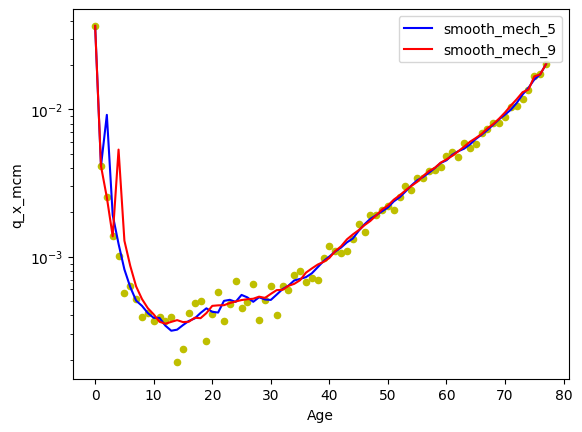

In [51]:
fig, ax = plt.subplots()

df_mmli.plot(kind='scatter', y='q_x_mcm', x='Age', c='y', logy=True, ax=ax)
df_mmli.plot(kind='line', y='smooth_mech_5', x='Age', c='b', logy=True, ax=ax)
df_mmli.plot(kind='line', y='smooth_mech_9', x='Age', c='r', logy=True, ax=ax)
plt.xlabel('Age')
plt.legend()
plt.show()

There is an obvious issue with smoothing at the border of the rates, since near birth mortality rates decrease sharply the average at the border creates signifficant unwated jump. Could be fixed separately but will be solved with more advanced methods. Ie Whittaker-Henderson or alternatevly by applying cubic splines

##### Whittaker-Henderson

In [52]:
from scipy.special import comb

In [178]:
# define matrix K of forward difference coefficicents 

def wh_fd_k(age_range, degree):
    """Function outputs matrix K of coefficients of discreete derivative/discrete forward difference
       used in Wittaker-Henderson sommoothing model

    Args:
        x_range (int): span of ages to be smoothed, ex. span for ages between 0 and omega is omega + 1
        degree (int): degree of discrete forward difference
    """
    K = np.zeros(shape=(age_range-degree,age_range))
    for i, row in enumerate(K):
        for j in range(i,degree + i + 1):
            K[i,j]= (-1)**degree * (-1)**(j-i) * comb(degree,j-i)
    return K

def wh_optim(W, q_raw, smooth_coeff, degree):
    """_summary_

    Args:
        W (_type_): _description_
        q_raw (_type_): _description_
        smooth_coeff (_type_): _description_
        degree (_type_): _description_
    """
    K = wh_fd_k(len(q_raw), degree)
    return np.linalg.inv(W + smooth_coeff * (K.T @ K)) @ (W @ q_raw) 


In [180]:
# assume all q_x's are equally important and set weight matrix to diag_1
W = np.diag(np.ones(shape=df_mmli.shape[0]))

#run optimization and add to the mmli data frame
q_x_wh = wh_optim(W, df_mmli['q_x_mcm'], smooth_coeff=17, degree=20)
q_x_wh_2 = wh_optim(W, df_mmli['q_x_mcm'], smooth_coeff=8, degree=10)
df_mmli['q_x_wh'] = q_x_wh
df_mmli['q_x_wh_2'] = q_x_wh_2


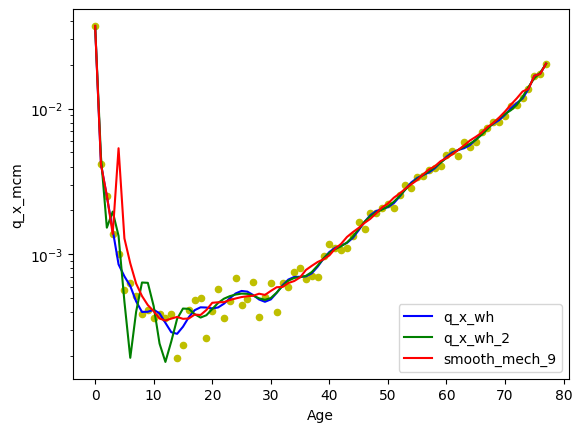

In [181]:
#graph mechanical and WH smoothing 
fig, ax = plt.subplots()

df_mmli.plot(kind='scatter', y='q_x_mcm', x='Age', c='y', logy=True, ax=ax)
df_mmli.plot(kind='line', y='q_x_wh', x='Age', c='b', logy=True, ax=ax)
df_mmli.plot(kind='line', y='q_x_wh_2', x='Age', c='g', logy=True, ax=ax)
df_mmli.plot(kind='line', y='smooth_mech_9', x='Age', c='r', logy=True, ax=ax)
plt.xlabel('Age')
plt.legend()
plt.show()

In [206]:
#it seems that observations at young age strongly skew the results, try choosing weights that would put more emphasis on the middle range
from scipy.stats import binom

w = [binom.pmf(k,df_mmli.shape[0],0.5) for k in range(df_mmli.shape[0])]
w = w/sum(w)

W = np.diag(w)

In [211]:
#run optimization and add to the mmli data frame
q_x_wh = wh_optim(W, df_mmli['q_x_mcm'], smooth_coeff=2, degree=3)
q_x_wh_2 = wh_optim(W, df_mmli['q_x_mcm'], smooth_coeff=4, degree=4)
df_mmli['q_x_wh'] = q_x_wh
df_mmli['q_x_wh_2'] = q_x_wh_2


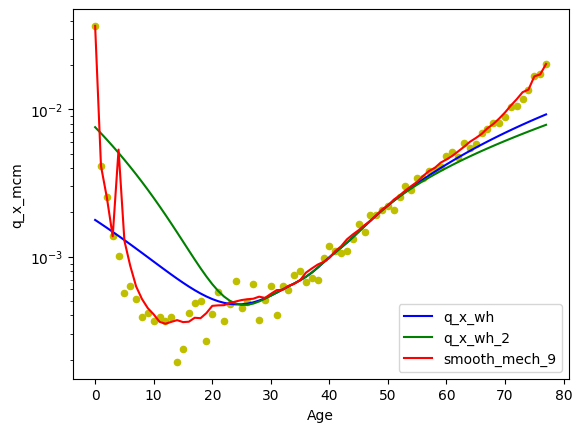

In [212]:
#graph mechanical and WH smoothing 
fig, ax = plt.subplots()

df_mmli.plot(kind='scatter', y='q_x_mcm', x='Age', c='y', logy=True, ax=ax)
df_mmli.plot(kind='line', y='q_x_wh', x='Age', c='b', logy=True, ax=ax)
df_mmli.plot(kind='line', y='q_x_wh_2', x='Age', c='g', logy=True, ax=ax)
df_mmli.plot(kind='line', y='smooth_mech_9', x='Age', c='r', logy=True, ax=ax)
plt.xlabel('Age')
plt.legend()
plt.show()

##### Smoothing wiht cubic splines